In [11]:
"""
This code has been slightly modified with respect to orginal source script
available at https://github.com/juangallostra/augmented-reality, 
developed by the Juan Gallostra Acín.
Furthermore the source code has been adapted to be executed in jupyter environment.
"""

# Useful links
# http://www.pygame.org/wiki/OBJFileLoader
# https://rdmilligan.wordpress.com/2015/10/15/augmented-reality-using-opencv-opengl-and-blender/
# https://clara.io/library
# https://bitesofcode.wordpress.com/2017/09/12/augmented-reality-with-python-and-opencv-part-1/
# https://bitesofcode.wordpress.com/2018/09/16/augmented-reality-with-python-and-opencv-part-2/

# TODO -> Implement the possibility of setting some parameters(e.g. model and object to be projected)
#      -> Refactor and organize code (proper funcition definition and separation, classes, error handling...)
#      -> Refine the estimation of the projection matrix by minimization of reprojection error
#      -> Error handling

import cv2
import numpy as np
import math
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import os
from objloader_simple import *
from time import sleep

# Minimum number of matches that have to be found
# to consider the recognition valid
MIN_MATCHES = 12
RECTANGLE = True    # if True draw a rectangle that marks the found reference image in the frame
CIRCLE = False      # if True draw a circle centered over the found reference image in the frame
MATCHES = True    # if True draw the discovered matches
MODEL3D = True      # if True draw the model 3D centered over the found reference image in the frame
SCALE_3D = 2        # scale for rendering the model 3D

In [12]:
def render(img, obj, projection, reference_image, scale3d, color=False):
    """
    Render a loaded obj model into the current video frame
    """
    vertices = obj.vertices
    scale_matrix = np.eye(3) * scale3d
    h, w = reference_image.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)
        if color is False:
            cv2.fillConvexPoly(img, imgpts, (137, 27, 211))
        else:
            color = hex_to_rgb(face[-1])
            color = color[::-1]  # reverse
            cv2.fillConvexPoly(img, imgpts, color)

    return img

def projection_matrix(camera_parameters, homography):
    """
    From the camera calibration matrix and the estimated homography
    compute the 3D projection matrix
    This method makes some simplifying assumptions and cannot work satisfactory in some cases
    """
    # Compute rotation along the x and y axis as well as the translation
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    return np.dot(camera_parameters, projection)

def hex_to_rgb(hex_color):
    """
    Helper function to convert hex strings to RGB
    """
    hex_color = hex_color.lstrip('#')
    h_len = len(hex_color)
    return tuple(int(hex_color[i:i + h_len // 3], 16) for i in range(0, h_len, h_len // 3))

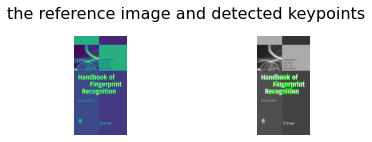

In [13]:
# initialization
"""
aftes initialization of camera parameters
loads the target surface image and computes keypoints and related descriptors
"""
homography = None 
# matrix of camera parameters (made up but works quite well for me) 
camera_parameters = np.array([[560, 0, 320], [0, 560, 240], [0, 0, 1]])
# create ORB keypoint detector
orb = cv2.ORB_create()
# create BFMatcher object based on hamming distance  
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# load the reference surface that will be searched in the video stream
dir_name = '../'
reference_image = cv2.imread(os.path.join(dir_name, 'reference/model.jpg'), 0)
fig1 = plt.figure(1)
fig1.suptitle('the reference image and detected keypoints', fontsize=16)
plt.subplot(2, 2, 1)
plt.imshow(reference_image)

plt.axis('off')
# Compute keypoints of the reference image and related descriptors
kp_reference_image, des_reference_image = orb.detectAndCompute(reference_image, None)
# show keypoints
img1 = cv2.drawKeypoints(reference_image, kp_reference_image, reference_image, color=(0,255,0), flags=0)
plt.subplot(2, 2, 2)
plt.imshow(img1)
plt.axis('off')

# save the image with detected keypoints
cv2.imwrite(filename=os.path.join(dir_name, 'saved_images/keypoints_reference_image.jpg'),img=img1)

# Load from OBJ file the 3D model to project to the current frame
obj = OBJ(os.path.join(dir_name, 'models/rat.obj'), swapyz=True)  


In [14]:
# real time image tracking

# init video capture
cap = cv2.VideoCapture(0)

while True:
    # read the current frame
    ret, frame = cap.read()
    if not ret:
        print ("Unable to capture video")
        break
    # find and draw the keypoints of the frame
    kp_frame, des_frame = orb.detectAndCompute(frame, None)
    cv2.imwrite(filename=os.path.join(dir_name, 'saved_images/saved_frame.jpg'),img=frame)
    # draw only keypoints location,not size and orientation
    #img2 = cv2.drawKeypoints(frame, kp_frame, frame, color=(0,255,0), flags=0)
    #cv2.imwrite(filename=os.path.join(dir_name, 'saved_images/keypoints.jpg'),img=img2)
    
    # match frame descriptors with reference image descriptors
    matches = bf.match(des_reference_image, des_frame)
    # sort them in the order of their distance
    # the lower the distance, the better the match
    matches = sorted(matches, key=lambda x: x.distance)

    # compute Homography if enough matches are found
    if len(matches) >= MIN_MATCHES:
        # differentiate between source points and destination points
        src_pts = np.float32([kp_reference_image[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        # compute Homography
        homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        if RECTANGLE:
            # Draw a rectangle that marks the found reference image in the frame
            h, w = reference_image.shape
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            # project corners into frame
            dst = cv2.perspectiveTransform(pts, homography)
            # connect them with lines  
            frame = cv2.polylines(frame, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
         
        if CIRCLE:
            # Draw a circle centered over the found reference image in the frame
            h, w = reference_image.shape
            pts = np.float32([(w - 1)/2, (h - 1)/2]).reshape(-1, 1, 2)
            # project into frame
            dst = cv2.perspectiveTransform(pts, homography)
            cx = (np.int32(dst).reshape(1,-1))[0][0]
            cy = (np.int32(dst).reshape(1,-1))[0][1]
            frame = cv2.circle(frame, (cx,cy), 10, (10, 255, 3), -1)
            
        # if a valid homography matrix was found render cube on model plane
        if homography is not None:
            try:
                 #draw image with matches before rendering the 3D model 
                 #frame_old = cv2.drawMatches(reference_image, kp_reference_image, frame, kp_frame, matches[:10], 0, flags=2)
                 #cv2.imwrite(filename=os.path.join(dir_name, 'saved_images/saved_img-before_rendering.jpg'),img=frame_old)
                 if MODEL3D:
                    # obtain 3D projection matrix from homography matrix and camera parameters
                    projection = projection_matrix(camera_parameters, homography)  
                    # project cube or model
                    frame = render(frame, obj, projection, reference_image, SCALE_3D, False)
            except:
                pass
        # draw first MIN_MATCHES matches.
        if MATCHES:
            #print(len(matches))
            frame = cv2.drawMatches(reference_image, kp_reference_image, frame, kp_frame, matches[:MIN_MATCHES], 0, flags=2)
            # show result
        cv2.imshow('frame', frame)
        # delay to adjust in order to obtain better rendering effects
        sleep(0.1)
        if cv2.waitKey(1) & 0xFF == ord('q'):
           cv2.imwrite(filename=os.path.join(dir_name, 'saved_images/saved_img-final.jpg'),img=frame)
           break

    else:
        print ("Not enough matches found - %d/%d" % (len(matches), MIN_MATCHES))

cap.release()
cv2.destroyAllWindows()

In [6]:
# there are still blocking situations, in these cases execute the following instructions to stop camera 
cap.release()
cv2.destroyAllWindows()